<a href="https://colab.research.google.com/github/Teoroo-CMC/DoE_Course_Material/blob/main/Week_2/Lab_1/Task_2/opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab: find optimum

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
from numpy.random import rand

%matplotlib inline

from numpy.random import rand, seed
import seaborn as sns
import scipy.stats as stats
from matplotlib.pyplot import *
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Experiment
This part defines you experiment. To get data from your experimental setup, just 

```python 
gaussian_function=(x, y, fwhm)
```

which will give you you result 

In [2]:
# Data generation. Doo not touch... This is your physical space :) 

def gaussian_function(x, y, pars=None, add_noise=False):
    # to be changed: genereate all data here
    np.random.seed(2)
    if not pars:
        x0 = np.random.randn(1)[0]+0.5
        y0 = x0+0.5
        fwhm = np.random.normal(loc=1.5,scale=3, size=100).mean()
    else:
        x0, y0, fwhm = pars
        
    func = 10*np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)
    
    if add_noise:
        func = add_noise_func(func)
    
    return func, x0, y0, fwhm

def add_noise_func(input_data, mean_noise=0):
    # incomplete: refactor code to generate data + noise in one function
    avg_data = np.mean(input_data)
    noise_ = np.random.normal(mean_noise, np.sqrt(avg_data), 1)[0]
    output_data = input_data + noise_
    
    return output_data



This is how you call for experimental data at x=1 and y=1: 

In [4]:
gaussian_function(1,1)[0]

1.5879227876724087

In [3]:
#Define the dictionary
inputs_labels = {'x1' : 'x1',
                 'y1' : 'y1'} 

dat = [('x1',0.2,0.3,0.4),
       ('y1',0.2,0.3,0.4)]


inputs_df = pd.DataFrame(dat,columns=['index','low','center','high'])
inputs_df = inputs_df.set_index(['index'])
#Create a function to insert the data and label
inputs_df['label'] = inputs_df.index.map( lambda z : inputs_labels[z] )

inputs_df

,low,center,high,label
index,,,,
x1,0.2,0.3,0.4,x1
y1,0.2,0.3,0.4,y1


In [33]:
# compute averages and span
inputs_df['average'] = inputs_df.apply( lambda z : ( z['high'] + z['low'])/2 , axis=1)
inputs_df['span'] = inputs_df.apply( lambda z : ( z['high'] - z['low'])/2 , axis=1)

# encode the data
inputs_df['encoded_low'] = inputs_df.apply( lambda z : ( z['low']  - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_center'] = inputs_df.apply( lambda z : ( z['center'] - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_high'] = inputs_df.apply( lambda z : ( z['high'] - z['average'] )/( z['span'] ), axis=1)

#inputs_df = inputs_df.drop(['average','span'],axis=1)

inputs_df

,low,center,high,label,encoded_low,encoded_center,encoded_high,average,span
index,,,,,,,,,
x1,0.2,0.3,0.4,x1,-1.0,-5.551115e-16,1.0,0.3,0.1
y1,0.2,0.3,0.4,y1,-1.0,-5.551115e-16,1.0,0.3,0.1


In [5]:
#display every possible combination of the extreme (high and low values)

import itertools
encoded_inputs= list(itertools.product([-1,1],[-1,1]))
encoded_inputs
for i in range(0,1):
    encoded_inputs.append((0,0))
encoded_inputs

[(-1, -1), (-1, 1), (1, -1), (1, 1), (0, 0)]

In [6]:
#couple the encoded results with the daaframe
results=pd.DataFrame(encoded_inputs)
results.columns=['x1','y1']
results

,x1,y1
0,-1,-1
1,-1,1
2,1,-1
3,1,1
4,0,0


Use DoE and factioral design to locate the maxima. 

In [7]:
#Couple the real experimental values with the different combinations
real_experiment = results
var_labels = []
for var in ['x1','y1']:
    var_label = inputs_df.loc[var]['label']
    var_labels.append(var_label)
    real_experiment[var_label] = results.apply(
        lambda z : inputs_df.loc[var]['low'] if z[var]<0 else (inputs_df.loc[var]['high'] if z[var]>0 else inputs_df.loc[var]['center']), 
        axis=1)

print("The values of each real variable in the experiment:")
real_experiment[var_labels]

The values of each real variable in the experiment:


,x1,y1
0,0.2,0.2
1,0.2,0.4
2,0.4,0.2
3,0.4,0.4
4,0.3,0.3


In [9]:
#Calculate the respons for each scenario 
y = []

for i in range(0,len(real_experiment)):
    y.append(gaussian_function(real_experiment['x1'][i],real_experiment['y1'][i])[0])
results['Respons'] = y
results


,x1,y1,Respons
0,0.2,0.2,7.473345
1,0.2,0.4,9.179031
2,0.4,0.2,6.385428
3,0.4,0.4,7.842812
4,0.3,0.3,7.938786


Getting new x and y values

In [63]:
#Making dataframe with encoded results and response
results1=pd.DataFrame(encoded_inputs)
y_df = pd.DataFrame(y)
results1 = [results1,y_df]
#merging two dataframes
results1 = pd.concat(results1,axis=1)
results1.columns=['z1','z2','Respons']
print(results1)


   z1  z2   Respons
0  -1  -1  7.473345
1  -1   1  9.179031
2   1  -1  6.385428
3   1   1  7.842812
4   0   0  7.938786


In [11]:
#Calculating the main effects

labels = ['z1','z2']
#avergge value of the results bar
print('ybar is', results1['Respons'].mean())
main_effects = {}

#loop over the group that you had
print('main effects')
for key in labels:
        average_effects = results1.groupby(key)['Respons'].mean()
        main_effects[key] = sum( [i*average_effects[i] for i in [-1,1]])
print(main_effects)

ybar is 7.76388074044695
main effects
{'z1': -1.2120680838087008, 'z2': 1.5815348570622323}


In [64]:
#Calculating the two-way effects
twoway_labels = list(itertools.combinations(labels, 2))


twoway_effects = {}
for key in twoway_labels:
    
    effects = results1.groupby([key[0],key[1]])['Respons'].mean()
    
    twoway_effects[key] = sum([ i*j*effects[i][j]/2 for i in [-1,1] for j in [-1,1] ])
twoway_effects

{('z1', 'z2'): -0.124150881382036}

In [28]:
#Put all effects in one dataframe

effects=[] #pd.DataFrame({})
indexes=[]
for i,k in enumerate(main_effects.keys()):
    effects.append(abs(main_effects[k]))
    indexes.append(k)
for i,k in enumerate(twoway_effects.keys()):
    effects.append(abs(twoway_effects[k]))
    indexes.append(k)
  
    
effects_df=pd.DataFrame({"Standardized effect":effects})

# reset the indexes
effects_df.index=indexes
# Sort values in descending order
effects_df = effects_df.sort_values(by='Standardized effect', ascending=False)
# Add cumulative percentage column
effects_df["cum_percentage"] = round(effects_df["Standardized effect"].cumsum()/effects_df["Standardized effect"].sum()*100,2)

# Display data frame
effects_df

,Standardized effect,cum_percentage
z2,1.581535,54.20
z1,1.212068,95.74
"(z1, z2)",0.124151,100.00


In [13]:
#Calculate function

s = "yhat = "

s += "%0.3f "%(results1['Respons'].mean())

for i,k in enumerate(main_effects.keys()):
    if(main_effects[k]<0):
        s += "%0.3f %s "%(main_effects[k]/2.0, k )
    else:
        s += "+ %0.3f %s "%(main_effects[k]/2.0, k )

for i,k in enumerate(twoway_effects.keys()):
    if(twoway_effects[k]<0):
        s += " %0.3f %s %s"%( twoway_effects[k]/2.0, k[0],k[1])
    else:
        s += "+ %0.3f %s %s"%( twoway_effects[k]/2.0, k[0],k[1])

print(s)

yhat = 7.764 -0.606 z1 + 0.791 z2  -0.062 z1 z2


In [65]:
#Getting all values in summary (fast way)
y = results['Respons']
xlabs=['z1','z2']
x = results1[xlabs]
x = sm.add_constant(x)

#smf.ols is a modelling package, fit formula for the results
res1 = smf.ols(formula='y ~ z1 + z2 + z1:z2', data=results1).fit()

res1.summary()

C:\Users\tampa920\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     34.74
Date:                Thu, 15 Jun 2023   Prob (F-statistic):              0.124
Time:                        16:42:29   Log-Likelihood:                 5.0886
No. Observations:                   5   AIC:                            -2.177
Df Residuals:                       1   BIC:                            -3.739
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.7639      0.087     88.778      0.007       6.653       8.875
z1            -0.6060      0.098     -6.198      0.102      -1.848       0.636
z2             0.7908      0.098      8.088      0.078      -0.452       2.033
z1:z2         -0.0621      0.098     -0.635      0.640      -1.304       1.180
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.250
Prob(Omnibus):                    nan   Jarque-Bera (JB):                1.888
Skew:                           1.500   Prob(JB):                        0.389
Kurtosis:                       3.250   Cond. No.                         1.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
#See that we can exclude z1xz2 factor, since it has little impact (10%, seen from cumalative percentage).
#However, I will include it in my calculation
#Now we want to find maximum of yhat
#Need to find delta values based on the coefficients for our yhat function.

# Define origin
origin = [0, 0]

# Get coefficient 
coefficients = {
    'z1': res1.params['z1'],
    'z2': res1.params['z2'],
    'z1:z2': res1.params['z1:z2']
}

# Compute delta based on coefficients
delta_z1 = -0.2
delta_z2 = delta_z1 * coefficients['z1'] / coefficients['z2']
delta = [delta_z1, delta_z2]

march = []
for i in range(0, 100):
    # Predict the next (x,y) point based on the regression model
    next_point = {
        'z1': origin[0] + (i + 1) * delta[0],
        'z2': origin[1] + (i + 1) * delta[1]
    }
    march.append(next_point)

# Decode x and y values and call function in order to get the respons data to find maximun.
March = pd.DataFrame(march, columns=['z1', 'z2'])
March['z1_decoded'] = (March['z1'] * inputs_df['span']['x1'] + inputs_df['average']['x1'])
March['z2_decoded'] = (March['z2'] * inputs_df['span']['y1'] + inputs_df['average']['y1'])
March['w'] = gaussian_function(March['z1_decoded'], March['z2_decoded'])[0]

March

,z1,z2,z1_decoded,z2_decoded,w
0,-0.2,0.153277,0.28,0.315328,8.183304
1,-0.4,0.306555,0.26,0.330655,8.415939
2,-0.6,0.459832,0.24,0.345983,8.635267
3,-0.8,0.613110,0.22,0.361311,8.839918
4,-1.0,0.766387,0.20,0.376639,9.028591
...,...,...,...,...,...
95,-19.2,14.714634,-1.62,1.771463,0.003993
96,-19.4,14.867912,-1.64,1.786791,0.003299
97,-19.6,15.021189,-1.66,1.802119,0.002720
98,-19.8,15.174467,-1.68,1.817447,0.002237


Text(0, 0.5, 'Yield')

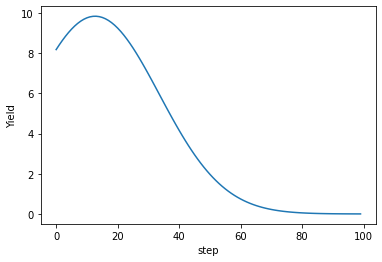

In [56]:
# Plot response values to see maximum value visially 
ax = March['w'].plot()
ax.set_xlabel("step")
ax.set_ylabel("Yield")

Thereby, the maximum can be found in the vector w, and also seen in the figure above. 

In [62]:
# Find maximum point
max_point = March.loc[March['w'].idxmax()]
print('The maximum point is:', max_point['w'])



The maximum point is: 9.843146157879355
